# **Github access**

--insert the GITHUB REPO ----

In [149]:
!git clone https://github.com/BaTNikolas/Image_recogntion_project/tree/main

Cloning into 'main'...
fatal: repository 'https://github.com/BaTNikolas/Image_recogntion_project/tree/main/' not found


# **Load DATASET**

---- Dataset is a zip file loaded in a drive folder --------
Alternatively you can download it from the link
https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors

In [1]:
import zipfile
!unzip /content/drive/MyDrive/rock_paper_final_project.zip

Archive:  /content/drive/MyDrive/rock_paper_final_project.zip
replace README_rpc-cv-images.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


# **Preliminary imports**

In [ ]:
! pip install xgboost

In [2]:
import pandas as pd
import numpy as np
#Image preprocessing
from glob import glob
import cv2
from google.colab.patches import cv2_imshow

#Visulaization
import seaborn as sns
import matplotlib.pyplot as plt
# Split the dataset
from sklearn.model_selection import train_test_split,cross_val_score
# Simple Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#Neural Networks
from sklearn.neural_network import MLPClassifier
#Ensemble models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, StackingClassifier , VotingClassifier
#Xgboost
from xgboost import XGBClassifier
# Metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score , precision_score, recall_score, f1_score
from sklearn.ensemble import StackingClassifier
import os,random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import warnings


# **Loading dataset attributes**

In [3]:
# import sys
lista_labels = ["rock","paper","scissors"]
total_images = []
total_images_for_model = []
count = 0
for la in lista_labels:
  folder = f"./{la}"
  for ima in os.listdir(folder):
    my_image= load_img(os.path.join(folder,ima),target_size=(30,30),color_mode="rgb")
    f_i = img_to_array(my_image) # Aυτό τώρα είναι array!
    f_i = f_i/255.0 #Normalization
    f_i = cv2.cvtColor(f_i,cv2.COLOR_RGB2GRAY)
    total_images.append((f_i,count))
  count +=1
random.shuffle(total_images)
random.shuffle(total_images_for_model)
X,y = zip(*total_images)


(2188, 30, 30) (30, 30)
(2188,)


# **Data visualization**
**Plotting 10 random images**

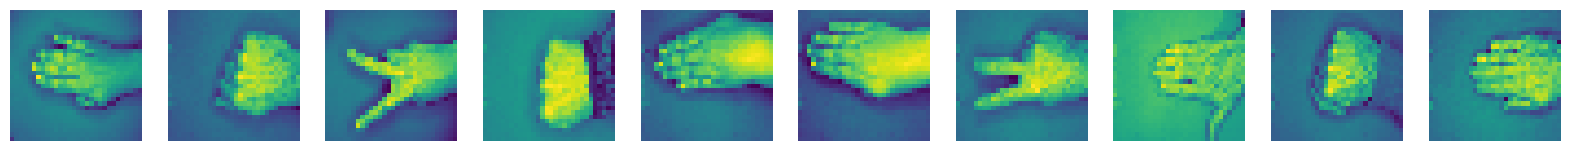

In [5]:
from random import randint
fig,ax =plt.subplots(1,10,figsize=(20,15))

for num in range(10):
  rand_num = randint(0,2187)
  ax[num].imshow(X[rand_num])
  ax[num].axis("off")
plt.show()



<Axes: ylabel='count'>

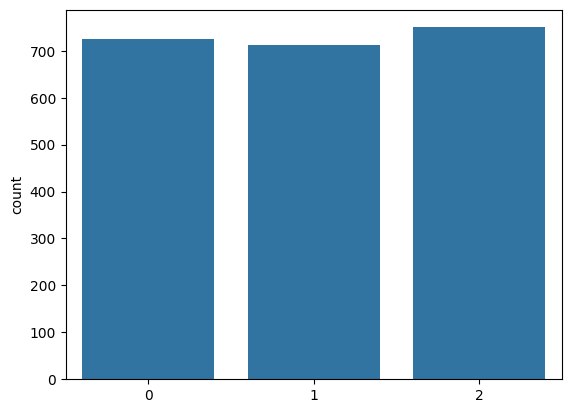

In [6]:
sns.countplot(x = y)

# **Dataset comment**

It is seen that all categories (0,1,2) with corresponding values ("rock","paper","scissors") are equally distributed among the dataset.

In [7]:
xtrain_cv , xtest_val_cv, ytrain_cv, ytest_val_cv = train_test_split(X,y,random_state=0,test_size=0.3, stratify=y)
xval_cv , xtest_cv, yval_cv, ytest_cv = train_test_split(xtest_val_cv,ytest_val_cv,random_state=0,test_size=0.3,stratify = ytest_val_cv) # 20% of the total dataset and 10 % of total so in 30 % its the same split


x_val_train_cv = np.concatenate((xtrain_cv,xval_cv)) #Unify the validation and the training set
x_val_train_cv_flatten= np.array([ el.flatten() for  el in x_val_train_cv])
x_train_flatten =  np.array([ el.flatten() for  el in xtrain_cv])
x_val_flatten =  np.array([ el.flatten() for  el in xval_cv])
x_Test_flatten =  np.array([ el.flatten() for  el in xtest_cv])
y_val_train_cv = np.concatenate((ytrain_cv,yval_cv)) # Unify the validation and the training set

# **Model Configuration**

Methodology constituted of the following steps:

1.   Find the optimal parameters  for every model by exploiting 5- Fold Cross validation or splitting the dataset in train (70%), validation (20%) and test (10%) set
2.   After the identification of the 3 best model an utilization of a stacking classifier consinst the final model for our project




# **Model evalualtion**
Regarding the development of rock-paper-scissors game as metric for all model is considered:


1.   F1-macro score is choosen because all classes are considered equally important for the selection of our model



# **Decision tree classifier**

In [8]:
max_depth,minimum_samples_leaf,criterion = [None,3,5],[2,5,10,20],['gini','entropy','log_loss']
chars_tree,f_1_score_tree_list =[],[]
for md in max_depth:
  for cr in criterion:
    for mleaf in minimum_samples_leaf:
      a_tree = DecisionTreeClassifier(criterion=cr, min_samples_leaf=mleaf,max_depth=md)
      f1_score_tree= abs(np.mean(cross_val_score(a_tree,X=x_val_train_cv_flatten,y=y_val_train_cv,scoring="f1_macro")))
      chars_tree.append(f"criterion_{cr}_max_D_{md}_min_leafs_{mleaf}")
      f_1_score_tree_list.append(f1_score_tree)

tree_dict ={
    "Characteristics":chars_tree,
    "f1 scores":f_1_score_tree_list
}
tree_df = pd.DataFrame(data = tree_dict)
final_tree_df=tree_df.sort_values(by="f1 scores",ascending=False)
print(final_tree_df.head())

                             Characteristics  f1 scores
5   criterion_entropy_max_D_None_min_leafs_5   0.800524
8  criterion_log_loss_max_D_None_min_leafs_2   0.800477
9  criterion_log_loss_max_D_None_min_leafs_5   0.799548
4   criterion_entropy_max_D_None_min_leafs_2   0.796129
6  criterion_entropy_max_D_None_min_leafs_10   0.786504


In [9]:
p_ex,n_neighbors,weights=['manhattan','euclidean','minkowski'],[5,15,round(np.sqrt(len(X))),100],["uniform","distance"]
chars_KNN,f_1_score_KNN_list =[],[]
for p in p_ex:
  for nei in n_neighbors:
    for w in weights:
      a_knn = KNeighborsClassifier(n_neighbors=nei,weights=w,metric=p)
      f1_score_KNN= abs(np.mean(cross_val_score(a_knn,X=x_val_train_cv_flatten,y=y_val_train_cv,scoring="f1_macro")))
      chars_KNN.append(f"distance_{p}_weight_{w}_weigh_{nei}")
      f_1_score_KNN_list.append(f1_score_KNN)

knn_dict ={
    "Characteristics":chars_KNN,
    "f1 scores":f_1_score_KNN_list
}
knn_df = pd.DataFrame(data = knn_dict)
final_knn_df=knn_df.sort_values(by="f1 scores",ascending=False)
print(final_knn_df.head())

                                Characteristics  f1 scores
1    distance_manhattan_weight_distance_weigh_5   0.907311
17   distance_minkowski_weight_distance_weigh_5   0.896159
9    distance_euclidean_weight_distance_weigh_5   0.896159
0     distance_manhattan_weight_uniform_weigh_5   0.890515
3   distance_manhattan_weight_distance_weigh_15   0.884007


# **SVM CLASSIFIER**



In [10]:
C_param, gam_param = [10,100,1000],['scale','auto']
chars_SVC,f_1_score_SVC_list =[],[]
kernel = ["linear", "poly", "rbf", "sigmoid"]
for k in kernel:
  for c_ in C_param:
    for gam in gam_param:
      a_SVC = SVC(gamma=gam,kernel=k,C=c_,probability=True,random_state=0)
      a_SVC.fit(x_train_flatten,ytrain_cv)
      preds = a_SVC.predict(x_val_flatten)
      f1_score_SVC = f1_score(yval_cv,preds,average="macro")
      chars_SVC.append(f"kernel_{k}_C_{c_}_g_{gam}")
      f_1_score_SVC_list.append(f1_score_SVC)


svc_dict_Dict ={
    "Characteristics":chars_SVC,
    "f1 scores":f_1_score_SVC_list
}
SVC_df = pd.DataFrame(data = svc_dict_Dict)
final_SVC_df=SVC_df.sort_values(by="f1 scores",ascending=False)
print(final_SVC_df.head())

               Characteristics  f1 scores
12     kernel_rbf_C_10_g_scale   0.956343
16   kernel_rbf_C_1000_g_scale   0.956343
14    kernel_rbf_C_100_g_scale   0.956343
10  kernel_poly_C_1000_g_scale   0.836000
6     kernel_poly_C_10_g_scale   0.836000


# **Multi layer pereceptron**

random state = 0
activation = 'relu'
hidden lay size
solver = 'lbfgs','sgd', 'adam'
aplha = 0.00001, 0.0001, 0.001
learning_rate = 'constant','adaptive' #είτε σταθερά κατά 0.001 αλλιώς στο adaptive μειώνεται κατά 5
early_stopping = True #When validation score is not improvig

In [11]:
warnings.filterwarnings("ignore")
hidden_layer_list,learning_rate_init_list,slover_list = [(64,),(64,64),(64,64,64,64),(256,),(256,256),(256,256,256,256)],[0.000000001,0.000001,0.001,1],["adam","sgd"]
f_1_score_mlp_list,chars_mlp  =[],[]
for hidden_lay in hidden_layer_list:
    for lear_list in learning_rate_init_list:
      for slo in slover_list:
        a_mlp = MLPClassifier(random_state=0,hidden_layer_sizes=hidden_lay,learning_rate ='constant',solver=slo,activation='relu',max_iter=400)
        a_mlp.fit(x_train_flatten,ytrain_cv)
        preds = a_mlp.predict(x_val_flatten)
        f1_score_mlp = f1_score(yval_cv,preds,average="macro")
        chars_mlp.append(f"layer size_{hidden_lay}_learning_rate_{lear_list}_solv{slo}")
        f_1_score_mlp_list.append(f1_score_mlp)

mlp_dict ={
    "Characteristics":chars_mlp,
    "f1 scores":f_1_score_mlp_list
}
mlp_df = pd.DataFrame(data = mlp_dict)
final_mlp_df=mlp_df.sort_values(by="f1 scores",ascending=False)
print(final_mlp_df.head())

                                   Characteristics  f1 scores
24  layer size_(256,)_learning_rate_1e-09_solvadam   0.945560
26  layer size_(256,)_learning_rate_1e-06_solvadam   0.945560
30      layer size_(256,)_learning_rate_1_solvadam   0.945560
28  layer size_(256,)_learning_rate_0.001_solvadam   0.945560
38  layer size_(256, 256)_learning_rate_1_solvadam   0.937139


In [14]:
n_estimator,learning_rate = [50,100,200,250],[0.0001,0.001,0.01]
f_1_score_ada_list,chars_ada  =[],[]
for n in n_estimator:
    for lr in learning_rate:
      a_ada = AdaBoostClassifier(learning_rate=lr,n_estimators=n)
      a_ada.fit(x_train_flatten,ytrain_cv)
      preds = a_ada.predict(x_val_flatten)
      # f1_score_ada = abs(np.mean(cross_val_score(a_ada,X=x_val_train_cv_flatten,y=y_val_train_cv,scoring="f1_macro")))
      f1_score_ada = f1_score(yval_cv,preds,average="macro")
      chars_ada.append(f"estimator_{n}_learning_rate_{lr}_and {b}")
      f_1_score_ada_list.append(f1_score_ada)
      # print(f" the f_1 for {f1_score_ada},estimator_{n}_learning_rate_{lr}_and {b}")


ada_dict ={
    "Characteristics":chars_ada,
    "f1 scores":f_1_score_ada_list
}
ADA_df = pd.DataFrame(data = ada_dict)
final_ada_df= ADA_df.sort_values(by="f1 scores",ascending=False)
print(final_ada_df.head())

                                      Characteristics  f1 scores
8   estimator_200_learning_rate_0.01_and SVC(C=10,...   0.659010
11  estimator_250_learning_rate_0.01_and SVC(C=10,...   0.652632
5   estimator_100_learning_rate_0.01_and SVC(C=10,...   0.607829
2   estimator_50_learning_rate_0.01_and SVC(C=10, ...   0.501204
7   estimator_200_learning_rate_0.001_and SVC(C=10...   0.460249


In [16]:
a_XG = XGBClassifier()
a_XG.fit(x_train_flatten,ytrain_cv)
preds = a_XG.predict(x_val_flatten)
f1_score_XG = f1_score(yval_cv,preds,average="macro")
print(f" the f_1 for {f1_score_XG} ")#, with g {gam} and kernel {k} and c parameter {c_}")

 the f_1 for 0.9585520138363742 


In [17]:
n_estimator,criteria,minimum_samples_splited = [50,100,200],['gini','entropy','log_loss'],[2,5,10,15]
accurancy_dict= {}
f_1_score__random_for_list,chars_random_forest =[],[]
for n in n_estimator:
  for cr in criteria:
    for min_s in minimum_samples_splited:
        a_forest = RandomForestClassifier(n_estimators=n,criterion=cr,min_samples_split=min_s)
        f1_score_random_forest= abs(np.mean(cross_val_score(a_forest,X=x_val_train_cv_flatten,y=y_val_train_cv,scoring="f1_macro")))

        chars_random_forest.append(f"esti_{n}_criter_{cr}_min_s{min_s}")
        f_1_score__random_for_list.append(f1_score_random_forest)

forest_Dict ={
    "Characteristics":chars_random_forest,
    "f1 scores":f_1_score__random_for_list
}
forest_df = pd.DataFrame(data = forest_Dict)
final_forest_df=forest_df.sort_values(by="f1 scores",ascending=False)
print(final_forest_df.head())

                    Characteristics  f1 scores
33  esti_200_criter_log_loss_min_s5   0.938086
32  esti_200_criter_log_loss_min_s2   0.936508
24      esti_200_criter_gini_min_s2   0.936063
25      esti_200_criter_gini_min_s5   0.935985
16   esti_100_criter_entropy_min_s2   0.935500


# **Stacking classifer**

#based on the best  5 models which consisted of XGBOOST, RANDOM-FOREST, KNN, MLP AND SVC

0.969655143568187
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        66
           1       0.98      0.95      0.97        64
           2       0.96      0.99      0.97        68

    accuracy                           0.97       198
   macro avg       0.97      0.97      0.97       198
weighted avg       0.97      0.97      0.97       198



<Axes: >

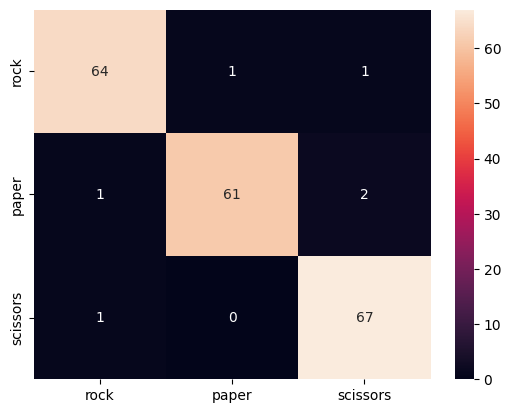

In [20]:
model_1 = XGBClassifier()
model_2 = RandomForestClassifier(n_estimators=200,criterion="log_loss",min_samples_split=5)
model_3 = KNeighborsClassifier(n_neighbors=5,weights='distance',metric='manhattan')
model_4 = MLPClassifier(random_state=0,hidden_layer_sizes=(256,),learning_rate ='constant',solver='adam',activation='relu',max_iter=400)
model_5 = SVC(gamma='scale',kernel='rbf',C=10)
esti = [('XG',model_1),("Ran_Forest",model_2),("KNN",model_3),("MLP",model_4)]
FINAL_MODEL = StackingClassifier(estimators=esti,final_estimator = model_5,n_jobs=-1)
FINAL_MODEL.fit(x_val_train_cv_flatten,y_val_train_cv) #Πάρe μαζί train/validation/test
preds_stack = FINAL_MODEL.predict(x_Test_flatten)
print(f1_score(ytest_cv,preds_stack,average="macro"))
print(classification_report(ytest_cv,preds_stack))
sns.heatmap(confusion_matrix(ytest_cv,preds_stack),xticklabels=["rock","paper","scissors"],yticklabels=["rock","paper","scissors"],annot=True)

# **Assumption about the model**
It is assumed that the final model achieves the best results among the other models and is choosed for the rock-paper-sciccor-game

# **Preprocess image**
Oppennet may flip image, vertically and horrizontaly, apply some noise in order to make it difficult for our agent to identify the image.



In [57]:
def opponent_manipulation(rand_array_img):
  def flip(image,flip_inp):
    new_image = np.array([0])
    if flip_inp[0] =="vertical":
      new_image = cv2.flip(image,0)
    elif flip_inp[0] =="horizontal":
      new_image= cv2.flip(image,1)
    elif flip_inp[0] =="Nothing":
      new_image=image

    return new_image

  opponent_list = ["vertical","horizontal","Nothing"]
  opponent_flip = random.choices(opponent_list,weights=[0.5,0.5,0.5])
  flip_image = flip(image=rand_array_img,flip_inp=opponent_flip)
  noise_sigma,noise_mean = 0.05,0


  noise = np.zeros(flip_image.shape,np.float32)
  cv2.randn(noise,noise_mean,noise_sigma)
  # #add noise
  noisy_image = cv2.add(flip_image,noise)

  return noisy_image

# **Opponent move**
(0,1,2) with corresponding values ("rock","paper","scissors")

In [78]:
def opponent_main():
  '''
  Function that refers to the opponent moves of rock-paper-scissors game
  '''
  pick_up_random_index = random.randint(0,2187)
  correct_answer = y[pick_up_random_index]
  selected_image = X[pick_up_random_index]
  manipulate_image =  opponent_manipulation(rand_array_img=selected_image)
  return correct_answer,manipulate_image
def player_choice(model_pred):
  if model_pred ==0:
    return 1
  elif model_pred == 1:
    return 2
  else:
    return 0


# **Main part of the game**

In [92]:
round_list,income_list = [],[]
avalable_total_money = 10
round_count= 1
moves_dictionary = {"0":"rock","1":"paper","2":"scissors"}
while(round_count!=100 and avalable_total_money!=0):
  correct_answer,image_to_identify = opponent_main()
  expand_shape_for_model =  image_to_identify[np.newaxis,:,:]
  image_flat = np.array([el.flatten() for el in expand_shape_for_model])
  best_model_pred = FINAL_MODEL.predict(image_flat)[0]
  model_move = player_choice (model_pred = best_model_pred)
  if best_model_pred != correct_answer:
    avalable_total_money -= 1
  else:
    avalable_total_money +=1
  round_list.append(round_count)
  income_list.append(avalable_total_money)
  round_count += 1

# **Visualization of the results**




Text(0.5, 1.0, 'Profit from accurate predicting of rock-paper-scissors game')

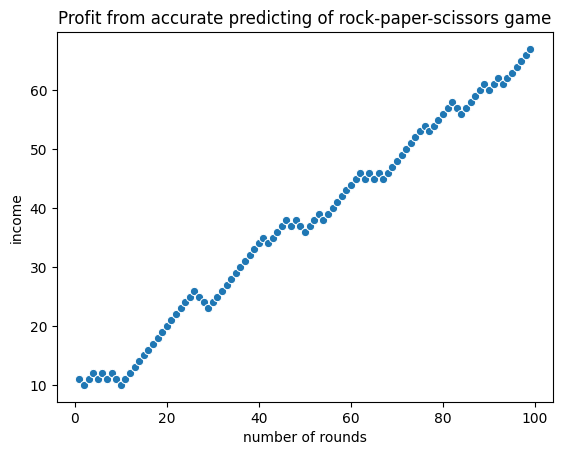

In [100]:
results_dict = {"number of rounds":round_list,"income":income_list}
results_df = pd.DataFrame(data=results_dict)
sns.lineplot(data=results_df,x='number of rounds',y='income',marker='o')
plt.title("Profit from accurate predicting of rock-paper-scissors game")

# **Testing model with a simillar image found in the google**
Image is a scissor shape hand and the expected return value is 2 from our final model

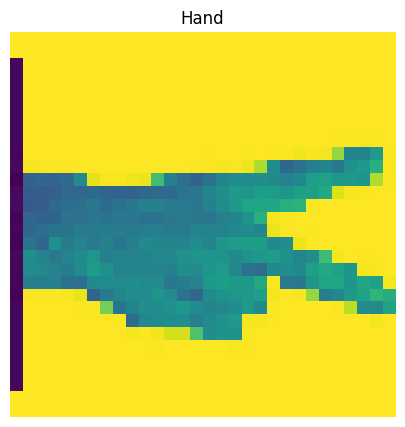

In [147]:
my_image_test= load_img('./hand.png',target_size=(30,30),color_mode="rgb")
test_f_i = img_to_array(my_image_test)
test_f_i = test_f_i/255.0 #Normalization
test_f_i = cv2.cvtColor(test_f_i,cv2.COLOR_RGB2GRAY)
fig_cha, axsi =plt.subplots(1,1,figsize=(10,5))
axsi.imshow(test_f_i)
axsi.axis("off")
axsi.set_title("Hand")
plt.show()


In [148]:
expand_shape_for_model_random =  test_f_i[np.newaxis,:,:] # To regulate according the model mandatory inputs
image_flat_random = np.array([el.flatten() for el in expand_shape_for_model_random])
best_model_pred_random = FINAL_MODEL.predict(image_flat_random )[0]
print(best_model_pred_random)

1
